In [1]:
# Section 1: Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
import gdown
import zipfile
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [2]:
# Download the entire Classification dataset as a zip file
url = "https://drive.google.com/file/d/1YW3f1IxXVHjTVSK_i3WwwlK5-BbjHAuE/view?usp=sharing"  # Direct link to the Google Drive file
output = "/content/classification.zip"

# Use gdown to download the file
gdown.download(url=url, output=output, fuzzy=True)

# Extract the downloaded zip file
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('/content/')


Downloading...
From (original): https://drive.google.com/uc?id=1YW3f1IxXVHjTVSK_i3WwwlK5-BbjHAuE
From (redirected): https://drive.google.com/uc?id=1YW3f1IxXVHjTVSK_i3WwwlK5-BbjHAuE&confirm=t&uuid=211d688f-75c0-47b6-9095-0145311eb77c
To: /content/classification.zip
100%|██████████| 369M/369M [00:08<00:00, 43.7MB/s]


In [3]:
  # Step 2: Load and Understand Annotations
  def load_annotations(csv_path):
      return pd.read_csv(csv_path, sep=';')

  train_annotations = load_annotations('/content/classification/data/train/Final_Training/GT_Train.csv')
  test_annotations = load_annotations('/content/classification/data/test/GT-final_test.csv')


In [4]:
# Function to preprocess images
def preprocess_image(image_path, bbox):
    if not os.path.exists(image_path):
        print(f"Image path does not exist: {image_path}")
        return None

    image = cv2.imread(image_path)  # or PIL.Image.open(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x1, y1, x2, y2 = bbox
    cropped_image = image[y1:y2, x1:x2]
    resized_image = cv2.resize(cropped_image, (32, 32))  # Resize to 32x32
    normalized_image = resized_image / 255.0  # Normalize pixel values
    return normalized_image

In [5]:

# Correct the function to load images and labels for training data
def load_train_images_and_labels(annotations, base_path):
    images = []
    labels = []
    for _, row in annotations.iterrows():
        class_id = f"{row['ClassId']:05d}"
        filename = row['Filename']
        # Construct the correct image path
        image_path = os.path.join(base_path, class_id, filename)
        bbox = (row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2'])
        label = row['ClassId']
        preprocessed_image = preprocess_image(image_path, bbox)
        if preprocessed_image is not None:
            images.append(preprocessed_image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Function to load images and labels for test data
def load_test_images_and_labels(annotations, base_path):
    images = []
    labels = []
    for _, row in annotations.iterrows():
        filename = row['Filename']
        image_path = os.path.join(base_path, filename)
        bbox = (row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2'])
        preprocessed_image = preprocess_image(image_path, bbox)
        if preprocessed_image is not None:
            images.append(preprocessed_image)
            labels.append(row['ClassId'])
    return np.array(images), np.array(labels)

# Ensure the paths to annotations are correct
print("Train Annotations Head:\n", train_annotations.head())
print("Test Annotations Head:\n", test_annotations.head())

Train Annotations Head:
           Filename  Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId
0  00000_00000.ppm     26      26       5       5      20      21       33
1  00000_00001.ppm     27      28       5       6      22      23       33
2  00000_00002.ppm     27      27       5       5      22      21       33
3  00000_00003.ppm     28      27       6       5      23      22       33
4  00000_00004.ppm     27      29       5       6      22      24       33
Test Annotations Head:
     Filename  Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId
0  00000.ppm     53      54       6       5      48      49       16
1  00001.ppm     42      45       5       5      36      40        1
2  00002.ppm     48      52       6       6      43      47       38
3  00003.ppm     27      29       5       5      22      24       33
4  00004.ppm     60      57       5       5      55      52       11


In [6]:
# Load images and labels
train_images, train_labels = load_train_images_and_labels(train_annotations, '/content/classification/data/train/Final_Training/Images')
test_images, test_labels = load_test_images_and_labels(test_annotations, '/content/classification/data/test/Final_Test/Images')

# Prepare data for training
num_classes = train_annotations['ClassId'].nunique()
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)



In [7]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=99)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).shuffle(buffer_size=1024)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


In [9]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)


In [10]:
# Define early stopping and model checkpoint callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=75,
    callbacks=callbacks
)

Epoch 1/75
981/981 [==============================] - 10s 5ms/step - loss: 1.6639 - accuracy: 0.5232 - val_loss: 0.3675 - val_accuracy: 0.9222
Epoch 2/75


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


981/981 [==============================] - 4s 4ms/step - loss: 0.5451 - accuracy: 0.8317 - val_loss: 0.1713 - val_accuracy: 0.9668
Epoch 3/75
981/981 [==============================] - 4s 4ms/step - loss: 0.3417 - accuracy: 0.8959 - val_loss: 0.0868 - val_accuracy: 0.9805
Epoch 4/75
981/981 [==============================] - 4s 4ms/step - loss: 0.2557 - accuracy: 0.9226 - val_loss: 0.0604 - val_accuracy: 0.9890
Epoch 5/75
981/981 [==============================] - 4s 4ms/step - loss: 0.2053 - accuracy: 0.9371 - val_loss: 0.0621 - val_accuracy: 0.9850
Epoch 6/75
981/981 [==============================] - 4s 4ms/step - loss: 0.1841 - accuracy: 0.9432 - val_loss: 0.0434 - val_accuracy: 0.9922
Epoch 7/75
981/981 [==============================] - 4s 4ms/step - loss: 0.1604 - accuracy: 0.9505 - val_loss: 0.0399 - val_accuracy: 0.9918
Epoch 8/75
981/981 [==============================] - 4s 4ms/step - loss: 0.1412 - accuracy: 0.9551 - val_loss: 0.0301 - val_accuracy: 0.9934
Epoch 9/75
981/98

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Predict on the test set
y_test_pred = model.predict(test_dataset)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true = np.argmax(test_labels, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(y_test_true, y_test_pred_classes)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Generate classification report
class_report = classification_report(y_test_true, y_test_pred_classes)
print('Classification Report:')
print(class_report)

395/395 [==============================] - 1s 2ms/step
Test Accuracy: 0.9747
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        60
           1       0.99      0.98      0.99       720
           2       0.99      1.00      0.99       750
           3       0.99      0.98      0.98       450
           4       0.99      0.98      0.99       660
           5       0.93      0.99      0.96       630
           6       1.00      0.91      0.95       150
           7       0.98      0.96      0.97       450
           8       0.97      0.95      0.96       450
           9       0.97      1.00      0.99       480
          10       1.00      0.98      0.99       660
          11       0.91      0.99      0.95       420
          12       1.00      0.98      0.99       690
          13       0.98      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.99      1.00  

In [14]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the "models" folder
model_folder_path = '/content/drive/My Drive/models'

# Create the "models" folder if it doesn't exist
if not os.path.exists(model_folder_path):
    os.makedirs(model_folder_path)

# Save the model to the "models" folder
model.save(os.path.join(model_folder_path, 'final_model_cnn_classifier.h5'))

print("Model saved to Google Drive in the 'models' folder.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to Google Drive in the 'models' folder.


In [16]:
# Dictionary mapping class IDs to names
class_id_to_name = {
    0: 'speed limit 20 (prohibitory)', 1: 'speed limit 30 (prohibitory)', 2: 'speed limit 50 (prohibitory)',
    3: 'speed limit 60 (prohibitory)', 4: 'speed limit 70 (prohibitory)', 5: 'speed limit 80 (prohibitory)',
    6: 'restriction ends 80 (other)', 7: 'speed limit 100 (prohibitory)', 8: 'speed limit 120 (prohibitory)',
    9: 'no overtaking (prohibitory)', 10: 'no overtaking (trucks) (prohibitory)', 11: 'priority at next intersection (danger)',
    12: 'priority road (other)', 13: 'give way (other)', 14: 'stop (other)', 15: 'no traffic both ways (prohibitory)',
    16: 'no trucks (prohibitory)', 17: 'no entry (other)', 18: 'danger (danger)', 19: 'bend left (danger)',
    20: 'bend right (danger)', 21: 'bend (danger)', 22: 'uneven road (danger)', 23: 'slippery road (danger)',
    24: 'road narrows (danger)', 25: 'construction (danger)', 26: 'traffic signal (danger)',
    27: 'pedestrian crossing (danger)', 28: 'school crossing (danger)', 29: 'cycles crossing (danger)',
    30: 'snow (danger)', 31: 'animals (danger)', 32: 'restriction ends (other)', 33: 'go right (mandatory)',
    34: 'go left (mandatory)', 35: 'go straight (mandatory)', 36: 'go right or straight (mandatory)',
    37: 'go left or straight (mandatory)', 38: 'keep right (mandatory)', 39: 'keep left (mandatory)',
    40: 'roundabout (mandatory)', 41: 'restriction ends (overtaking) (other)', 42: 'restriction ends (overtaking (trucks)) (other)'
}


1/1 [==============================] - 0s 70ms/step


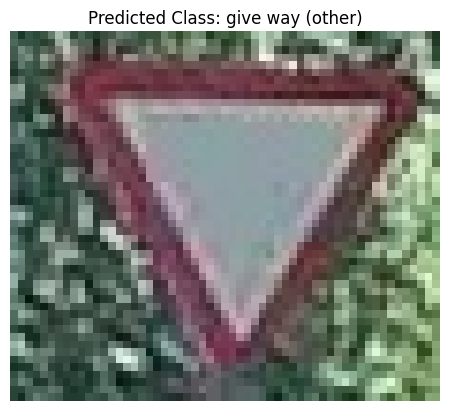

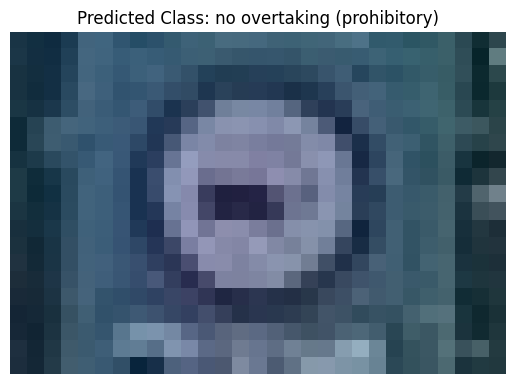

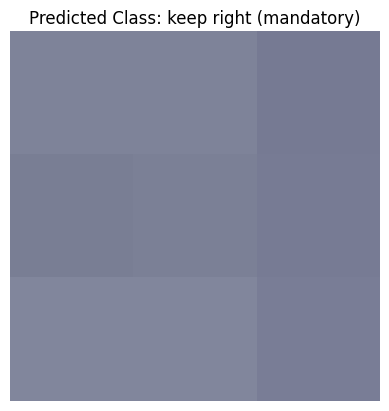

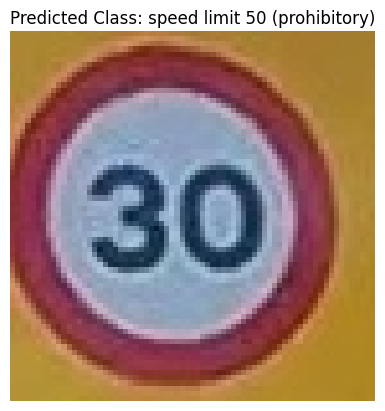

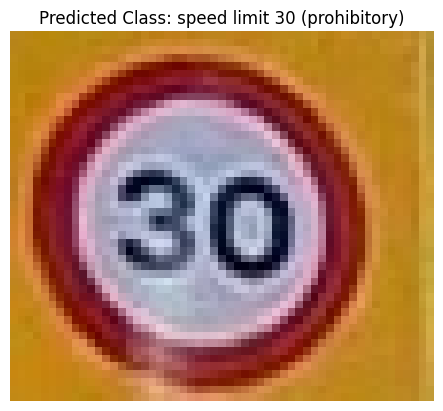

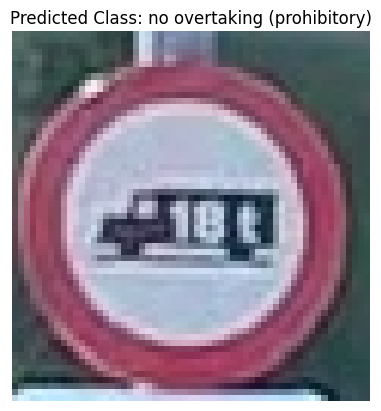

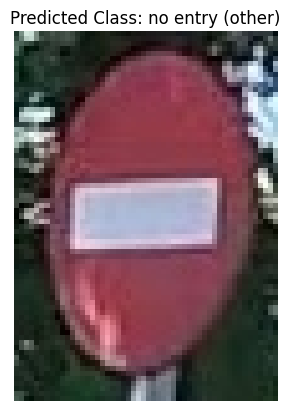

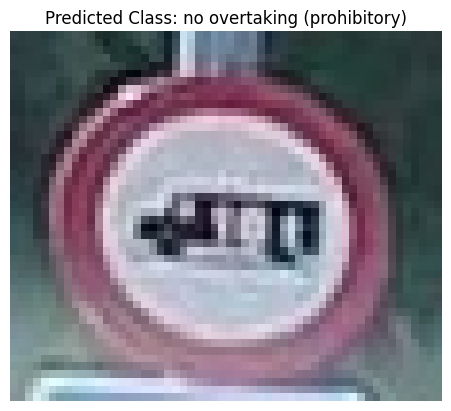

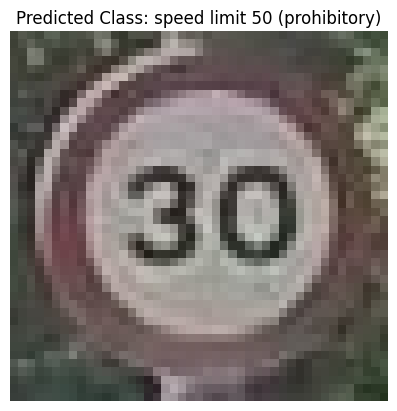

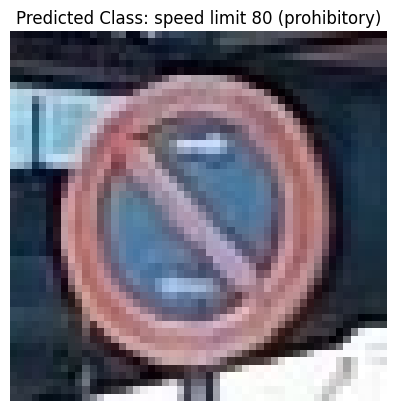

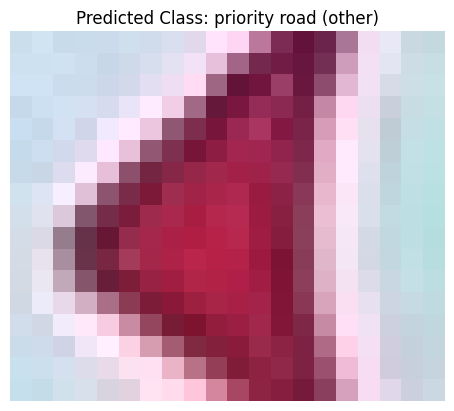

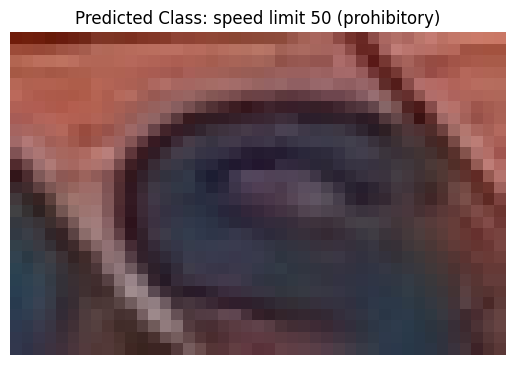

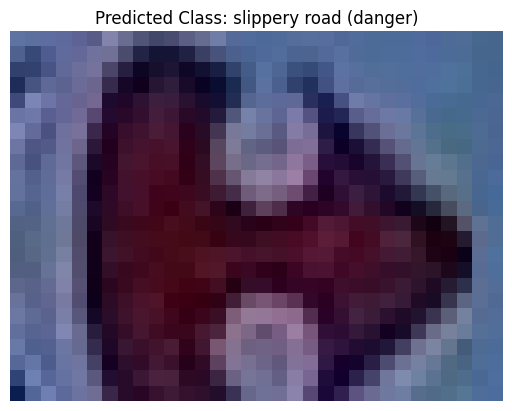

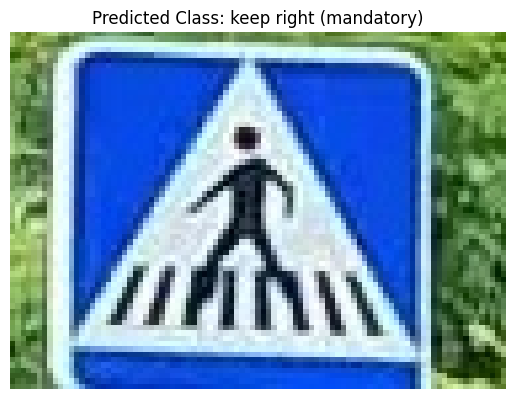

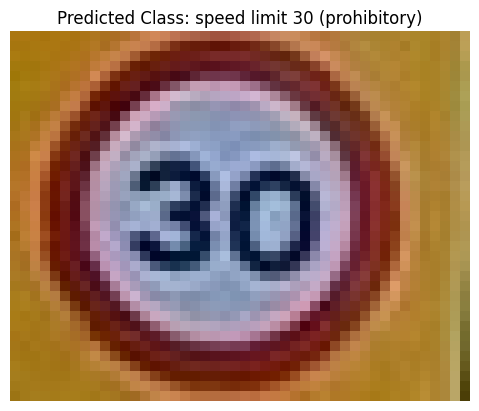

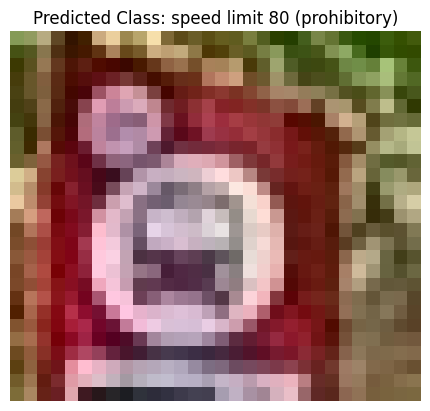

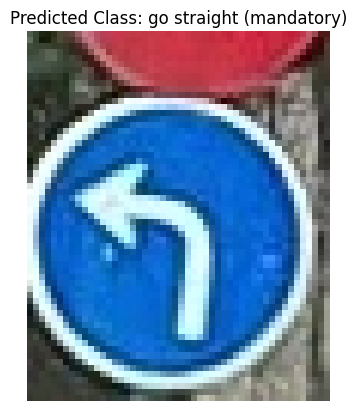

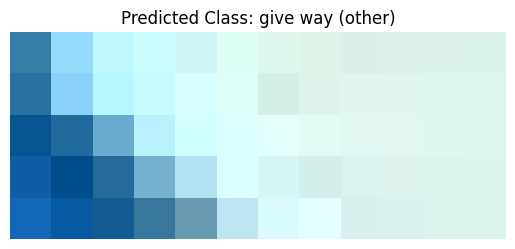

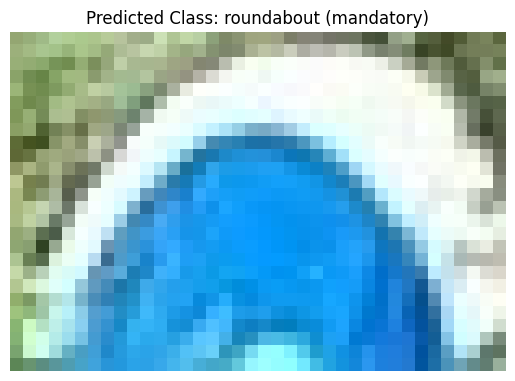

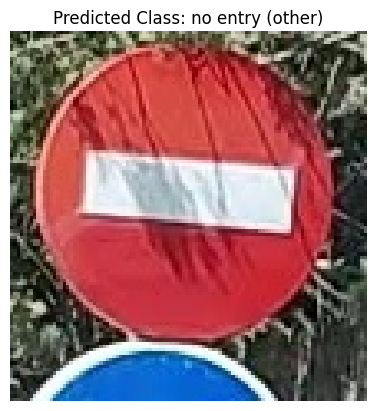

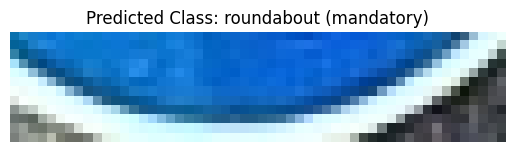

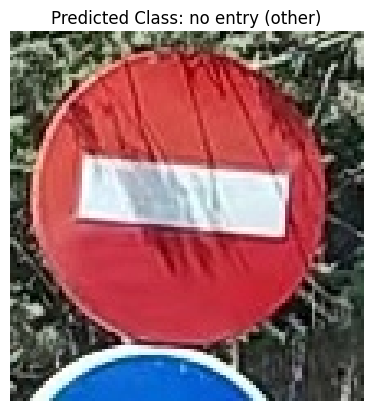

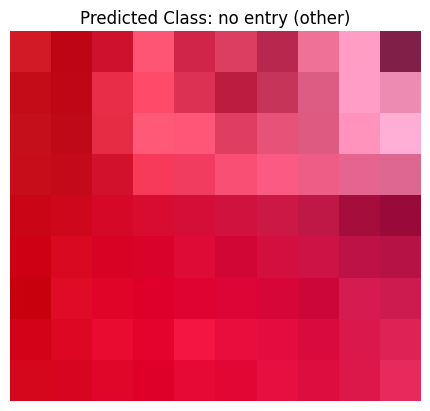

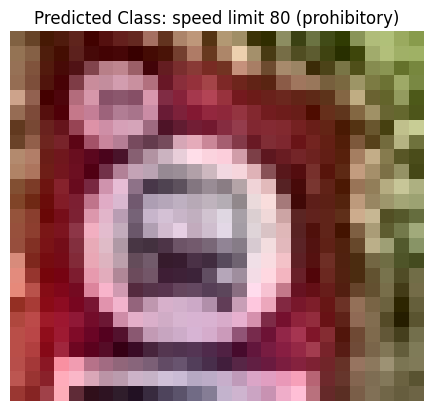

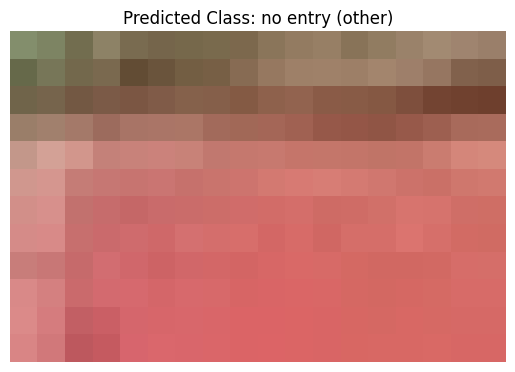

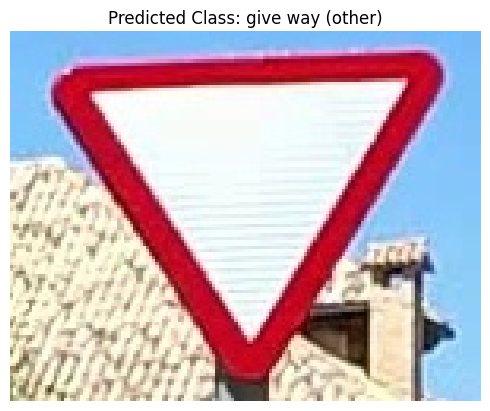

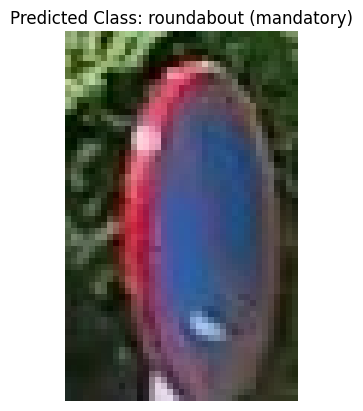

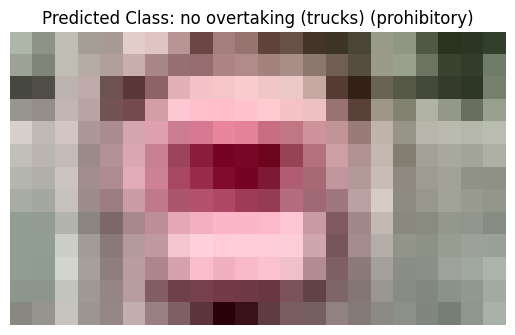

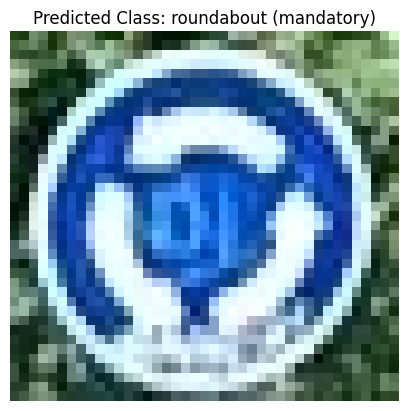

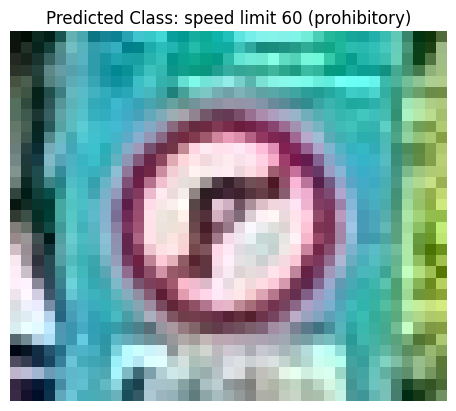

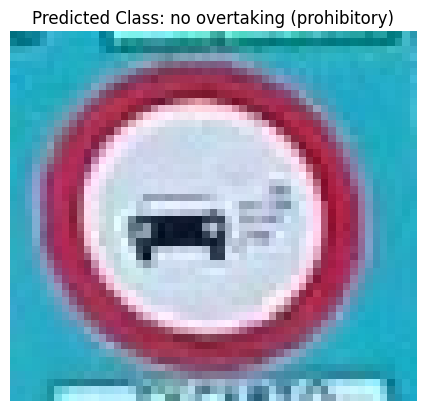

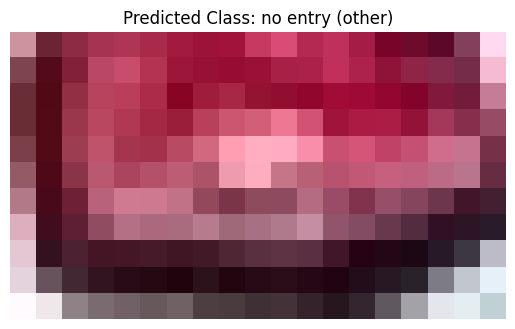

In [17]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from pathlib import Path
import os

# Path to your personal images
personal_images_path = '/content/drive/MyDrive/ROIsPersonal'

# Function to preprocess personal images
def preprocess_personal_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (32, 32))  # Resize to 32x32
    normalized_image = resized_image / 255.0  # Normalize pixel values
    return normalized_image

# Load all images from the personal images directory
def load_personal_images(personal_images_path):
    images = []
    image_names = []
    for image_file in os.listdir(personal_images_path):
        if image_file.endswith('.jpg'):
            image_path = os.path.join(personal_images_path, image_file)
            preprocessed_image = preprocess_personal_image(image_path)
            if preprocessed_image is not None:
                images.append(preprocessed_image)
                image_names.append(image_file)
    return np.array(images), image_names

# Load personal images
personal_images, image_names = load_personal_images(personal_images_path)

# Load the trained model
model_path = '/content/drive/My Drive/models/final_model_cnn_classifier.h5'
model = load_model(model_path)

# Make predictions on personal images
personal_images_predictions = model.predict(personal_images)
personal_images_pred_classes = np.argmax(personal_images_predictions, axis=1)

# Display the images with the predicted class names
for image_name, pred_class in zip(image_names, personal_images_pred_classes):
    image_path = os.path.join(personal_images_path, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.title(f"Predicted Class: {class_id_to_name[pred_class]}")
    plt.axis('off')
    plt.show()